### libraries

In [2]:
# Data loading
import torch
import random
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import shutil
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import os

# Train model

import torchvision.models as models
import torch.optim as optim
import torch.nn as nn

# Evaluate model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def create_dataset(folder_path):
    my_list = []
    for category in ['NORMAL', 'PNEUMONIA']:  # Iterate over the two classes
        category_path = os.path.join(folder_path, category)
        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            # Ensure we're only adding image files
            if os.path.isfile(file_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                my_list.append([file_path, category])
    return pd.DataFrame(my_list, columns=['file_path', 'label'])

def create_validation_set_from_train(train_dir, val_dir, num_files_per_class=10):
    os.makedirs(os.path.join(val_dir, 'NORMAL'), exist_ok=True)
    os.makedirs(os.path.join(val_dir, 'PNEUMONIA'), exist_ok=True)

    for category in ['NORMAL', 'PNEUMONIA']:
        category_path = os.path.join(train_dir, category)
        validation_category_path = os.path.join(val_dir, category)

        # Get all files in the category folder
        files = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        # Randomly select files to move
        selected_files = random.sample(files, min(num_files_per_class, len(files)))

        # Move selected files to the validation folder
        for file_name in selected_files:
            source = os.path.join(category_path, file_name)
            destination = os.path.join(validation_category_path, file_name)
            shutil.move(source, destination)

# Dataset paths
dataset_dir = '/s_home/mb906/proj/Proj/chest_xray'
train_dir = os.path.join(dataset_dir, 'train')
val_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')

# Create validation set by moving files from train directory
create_validation_set_from_train(train_dir, val_dir, num_files_per_class=10)

# Create DataFrames for train and validation datasets
train_df = create_dataset(train_dir)
val_df = create_dataset(val_dir)
test_df = create_dataset(test_dir)


# Convert labels to numeric: NORMAL -> 0, PNEUMONIA -> 1
train_df['label'] = train_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})
val_df['label'] = val_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})
test_df['label'] = test_df['label'].map({'NORMAL': 0, 'PNEUMONIA': 1})

# Print dataset sizes
print(f"Train set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Train set size: 5212
Validation set size: 20
Test set size: 624


In [4]:
def count_categories(df, dataset_name):
    category_counts = df['label'].value_counts()
    print(f"{dataset_name} set:")
    print(f"  NORMAL: {category_counts.get(0, 0)}")
    print(f"  PNEUMONIA: {category_counts.get(1, 0)}")

# Count and display for train, validation, and test datasets
print("Image Counts per Category:")
count_categories(train_df, "Train")
count_categories(val_df, "Validation")
count_categories(test_df, "Test")

Image Counts per Category:
Train set:
  NORMAL: 1339
  PNEUMONIA: 3873
Validation set:
  NORMAL: 10
  PNEUMONIA: 10
Test set:
  NORMAL: 234
  PNEUMONIA: 390


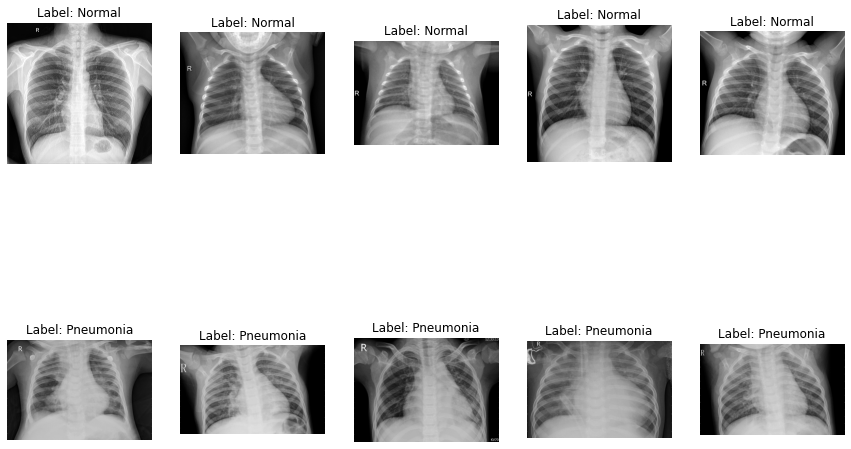

In [5]:
def visualize_samples(df, n_samples=5):
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 10))
    
    # Visualize 5 NORMAL samples
    normal_samples = df[df['label'] == 0].iloc[:n_samples]
    for i in range(n_samples):
        img_path = normal_samples.iloc[i, 0]
        label = normal_samples.iloc[i, 1]
        image = Image.open(img_path).convert('L')  # Open in grayscale (original format)
        axes[0, i].imshow(image, cmap='gray')
        axes[0, i].set_title(f"Label: {['Normal', 'Pneumonia'][label]}")
        axes[0, i].axis('off')
    
    # Visualize 5 PNEUMONIA samples
    pneumonia_samples = df[df['label'] == 1].iloc[:n_samples]
    for i in range(n_samples):
        img_path = pneumonia_samples.iloc[i, 0]
        label = pneumonia_samples.iloc[i, 1]
        image = Image.open(img_path).convert('L')  # Open in grayscale (original format)
        axes[1, i].imshow(image, cmap='gray')
        axes[1, i].set_title(f"Label: {['Normal', 'Pneumonia'][label]}")
        axes[1, i].axis('off')
        
    plt.show()

# Show 5 samples from the training data
visualize_samples(train_df)

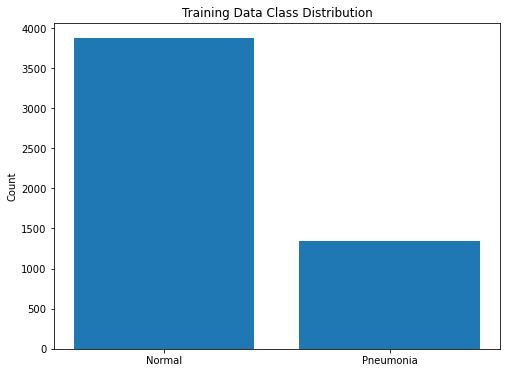

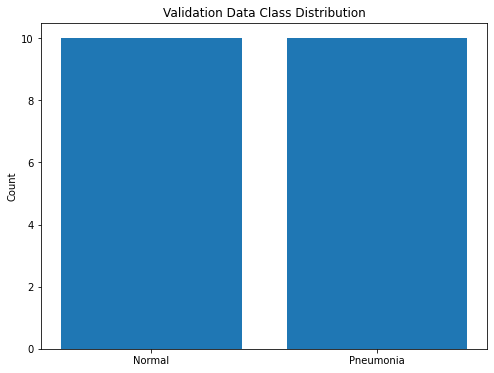

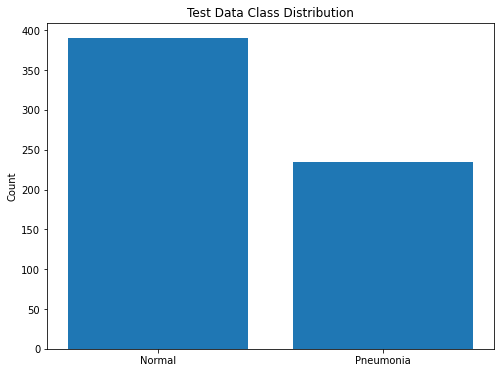

In [6]:
train_counts = train_df['label'].value_counts()
val_counts = val_df['label'].value_counts()
test_counts = test_df['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(['Normal', 'Pneumonia'], train_counts)
plt.title("Training Data Class Distribution")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(['Normal', 'Pneumonia'], val_counts)
plt.title("Validation Data Class Distribution")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(['Normal', 'Pneumonia'], test_counts)
plt.title("Test Data Class Distribution")
plt.ylabel("Count")
plt.show()

In [7]:
from PIL import Image

# Custom dataset class
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]  # Image path
        label = self.dataframe.iloc[idx, 1]     # Label (0 or 1)
        img = Image.open(img_path).convert('RGB')  # Convert to RGB if not already

        if self.transform:
            img = self.transform(img)

        return img, label

# Define transforms
train_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset_resnet = ImageDataset(train_df, transform=train_transform_resnet)
val_dataset_resnet = ImageDataset(val_df, transform=val_transform_resnet)
test_dataset_resnet = ImageDataset(test_df, transform=test_transform_resnet)

# Create DataLoaders
batch_size = 32
train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=batch_size, shuffle=True)
val_loader_resnet = DataLoader(val_dataset_resnet, batch_size=batch_size, shuffle=False)
test_loader_resnet = DataLoader(test_dataset_resnet, batch_size=batch_size, shuffle=False)



In [8]:

from sklearn.utils.class_weight import compute_class_weight

# Sample class distribution based on the dataset
class_labels = np.array([0, 1])  # 0: NORMAL, 1: PNEUMONIA
y_train = np.array([0]*1339 + [1]*3873)  # Example label array

# Calculate class weights using sklearn
class_weights = compute_class_weight('balanced', classes=class_labels, y=y_train)

print(f"Class weights: {dict(zip(class_labels, class_weights))}")

Class weights: {0: 1.9462285287528005, 1: 0.672863413374645}


In [9]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import torch
from torch import nn, optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
from torchvision.models import resnet18

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet-18 Model and modify for binary classification
model = resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False  # Freeze pre-trained weights
in_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(in_features, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Linear(32, 2),  # 2 output classes for binary classification
    nn.Sigmoid()
)
#model = model.to(device)  # Move model to the appropriate device
model.to(device)
#images, labels = images.to(device), labels.to(device)


# Enable multi-GPU support if available
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/user/25452/cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100.0%


In [10]:
def train_model_with_history(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10):
    log_file = 'training_log.txt'
    if os.path.exists(log_file):
        os.remove(log_file)

    train_losses, val_losses, test_losses = [], [], []
    train_accuracies, val_accuracies, test_accuracies = [], [], []

    with open(log_file, 'w') as log:
        log.write("Epoch, Train Loss, Train Accuracy, Val Loss, Val Accuracy, Test Loss, Test Accuracy\n")

        for epoch in range(num_epochs):
            # Training
            model.train()
            running_loss, correct, total = 0.0, 0, 0
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_loss = running_loss / len(train_loader)
            train_accuracy = 100 * correct / total
            train_losses.append(train_loss)
            train_accuracies.append(train_accuracy)

            # Validation
            model.eval()
            val_loss, val_correct, val_total = 0.0, 0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()

            val_loss /= len(val_loader)
            val_accuracy = 100 * val_correct / val_total
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            # Testing
            test_loss, test_correct, test_total = 0.0, 0, 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    test_total += labels.size(0)
                    test_correct += (predicted == labels).sum().item()

            test_loss /= len(test_loader)
            test_accuracy = 100 * test_correct / test_total
            test_losses.append(test_loss)
            test_accuracies.append(test_accuracy)

            print(f"Epoch [{epoch+1}/{num_epochs}] "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}% | "
                  f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")

            log.write(f"{epoch+1}, {train_loss:.4f}, {train_accuracy:.2f}, "
                      f"{val_loss:.4f}, {val_accuracy:.2f}, {test_loss:.4f}, {test_accuracy:.2f}\n")

    return train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies

In [11]:
# Optimizer and Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Train the model
history = train_model_with_history(
    model, train_loader_resnet, val_loader_resnet, test_loader_resnet, criterion, optimizer, num_epochs=10
)
#Unpack the history if it is not None
if history is not None:
    train_losses, val_losses, test_losses, train_accuracies, val_accuracies, test_accuracies = history
else:
    raise ValueError("The function train_model_with_history returned None")

Epoch [1/10] Train Loss: 0.4721, Train Acc: 92.21% | Val Loss: 0.3798, Val Acc: 95.00% | Test Loss: 0.4276, Test Acc: 91.35%
Epoch [2/10] Train Loss: 0.3784, Train Acc: 95.34% | Val Loss: 0.3752, Val Acc: 95.00% | Test Loss: 0.4281, Test Acc: 88.62%
Epoch [3/10] Train Loss: 0.3643, Train Acc: 95.55% | Val Loss: 0.3697, Val Acc: 95.00% | Test Loss: 0.4538, Test Acc: 85.42%
Epoch [4/10] Train Loss: 0.3596, Train Acc: 95.74% | Val Loss: 0.3429, Val Acc: 95.00% | Test Loss: 0.4719, Test Acc: 83.33%
Epoch [5/10] Train Loss: 0.3534, Train Acc: 96.20% | Val Loss: 0.3381, Val Acc: 100.00% | Test Loss: 0.4554, Test Acc: 84.29%
Epoch [6/10] Train Loss: 0.3538, Train Acc: 96.11% | Val Loss: 0.3781, Val Acc: 95.00% | Test Loss: 0.4928, Test Acc: 80.61%
Epoch [7/10] Train Loss: 0.3518, Train Acc: 96.07% | Val Loss: 0.3398, Val Acc: 100.00% | Test Loss: 0.4392, Test Acc: 86.86%
Epoch [8/10] Train Loss: 0.3500, Train Acc: 96.45% | Val Loss: 0.3522, Val Acc: 95.00% | Test Loss: 0.4630, Test Acc: 83.17

In [12]:
from sklearn.metrics import classification_report

# Collect true and predicted labels
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in test_loader_resnet:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())


In [13]:
# Calculate and display classification report
report = classification_report(true_labels, predicted_labels, target_names=['NORMAL', 'PNEUNOMIA'])
print(report)

              precision    recall  f1-score   support

      NORMAL       0.97      0.64      0.77       234
   PNEUNOMIA       0.82      0.99      0.90       390

    accuracy                           0.86       624
   macro avg       0.90      0.81      0.83       624
weighted avg       0.88      0.86      0.85       624



In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

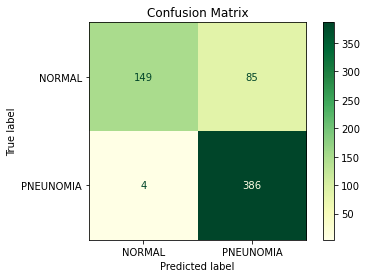

In [15]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUNOMIA'])
disp.plot(cmap=plt.cm.YlGn)
plt.title("Confusion Matrix")
plt.show()

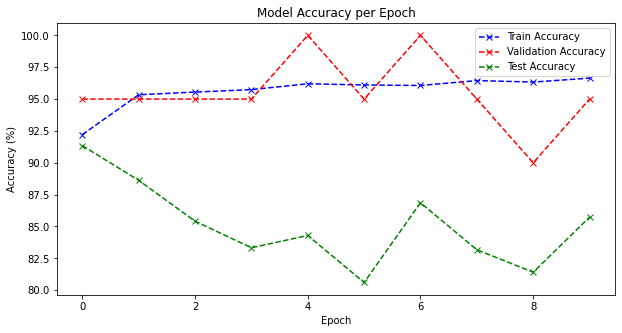

In [16]:
# Plotting accuracy for VGG16 with train, validation, and test
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Train Accuracy', color='blue', linestyle='--', marker='x')
plt.plot(val_accuracies, label='Validation Accuracy', color='red', linestyle='--', marker='x')
plt.plot(test_accuracies, label='Test Accuracy', color='green', linestyle='--', marker='x')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(False)  # No grid for accuracy plot
plt.show()

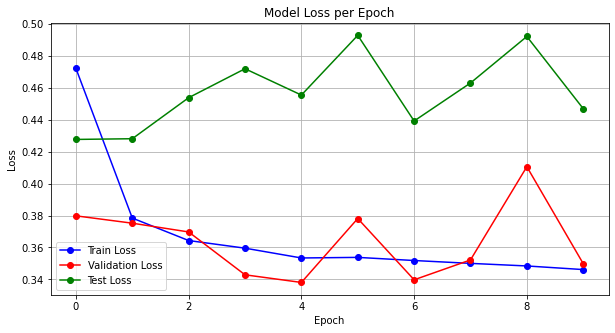

In [17]:
# Plotting loss for VGG16 with train, validation, and test
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')
plt.plot(val_losses, label='Validation Loss', color='red', linestyle='-', marker='o')
plt.plot(test_losses, label='Test Loss', color='green', linestyle='-', marker='o')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)  # Grid enabled for loss plot
plt.show()


Balanced Predictions from model:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

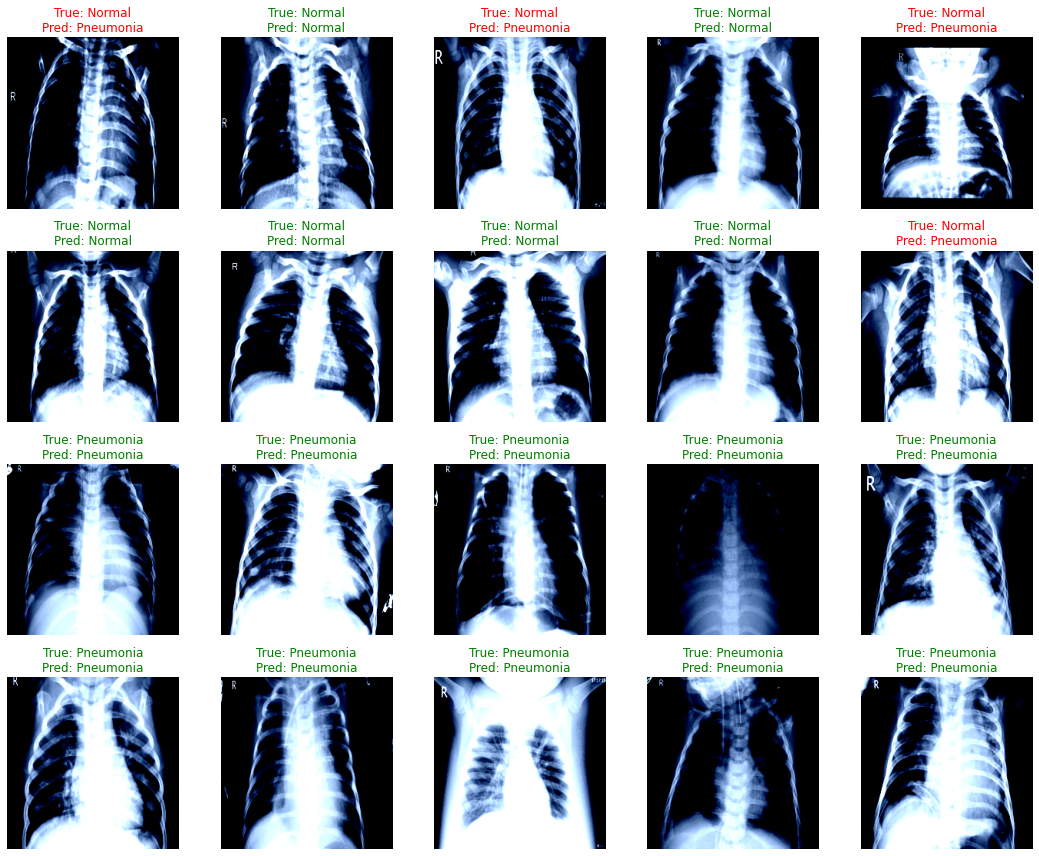

Balanced Accuracy: 0.7956
Class Normal: 149/234 correct
Class Pneumonia: 21/22 correct


In [18]:
import torch
import matplotlib.pyplot as plt

def show_balanced_predictions(model, test_loader, class_names, num_normal=10, num_pneumonia=10):
    """
    Display images with balanced true labels (Normal and Pneumonia).
    Highlight incorrect predictions in red.
    Also calculate and display balanced accuracy.
    """
    model.eval()  # Set the model to evaluation mode
    normal_images = []
    pneumonia_images = []

    # Metrics for calculating balanced accuracy
    class_correct = {0: 0, 1: 0}  # Correct predictions for each class
    class_total = {0: 0, 1: 0}    # Total samples for each class

    # Gather predictions for "Normal" and "Pneumonia" separately
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)

            for i in range(images.size(0)):
                # Convert image tensor to numpy array for display
                image = images[i].cpu().numpy().transpose(1, 2, 0)
                if image.shape[-1] == 1:  # Grayscale image
                    image = image.squeeze(-1)

                true_label = labels[i].item()
                pred_label = predictions[i].item()
                label_dict = {
                    "image": image,
                    "true_label": class_names[true_label],
                    "pred_label": class_names[pred_label],
                    "correct": true_label == pred_label,
                }

                # Update metrics
                class_total[true_label] += 1
                if true_label == pred_label:
                    class_correct[true_label] += 1

                # Collect images based on true labels
                if true_label == 0 and len(normal_images) < num_normal:
                    normal_images.append(label_dict)
                elif true_label == 1 and len(pneumonia_images) < num_pneumonia:
                    pneumonia_images.append(label_dict)

            # Break the loop if we have enough images
            if len(normal_images) >= num_normal and len(pneumonia_images) >= num_pneumonia:
                break

    # Combine images for display
    images_to_display = normal_images + pneumonia_images
    rows, cols = 4, 5  # Grid size
    fig, axes = plt.subplots(rows, cols, figsize=(15, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(images_to_display):
            img_dict = images_to_display[idx]
            image = img_dict["image"]
            true_label = img_dict["true_label"]
            pred_label = img_dict["pred_label"]
            correct = img_dict["correct"]

            # Title with green for correct, red for incorrect
            title_color = "green" if correct else "red"
            ax.imshow(image, cmap="grey" if image.ndim == 2 else None)
            ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=title_color)
            ax.axis("off")
        else:
            ax.axis("off")  # Empty cells

    plt.tight_layout()
    plt.show()

    # Calculate balanced accuracy
    balanced_accuracy = sum(class_correct[i] / class_total[i] for i in class_total if class_total[i] > 0) / len(class_total)
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    for label in class_names:
        print(f"Class {label}: {class_correct[class_names.index(label)]}/{class_total[class_names.index(label)]} correct")

print("Balanced Predictions from model:")
show_balanced_predictions(model, test_loader_resnet, class_names=["Normal", "Pneumonia"], num_normal=10, num_pneumonia=10)


In [19]:
from torchsummary import summary
summary(model, input_size=(3, 224, 224))  # Adjust input_size based on your model's expected input

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [20]:
torch.save(model.state_dict(), 'model.pth')